# Unscented Kalman Filter SLAM

In [34]:
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
%matplotlib notebook

<IPython.core.display.Javascript object>


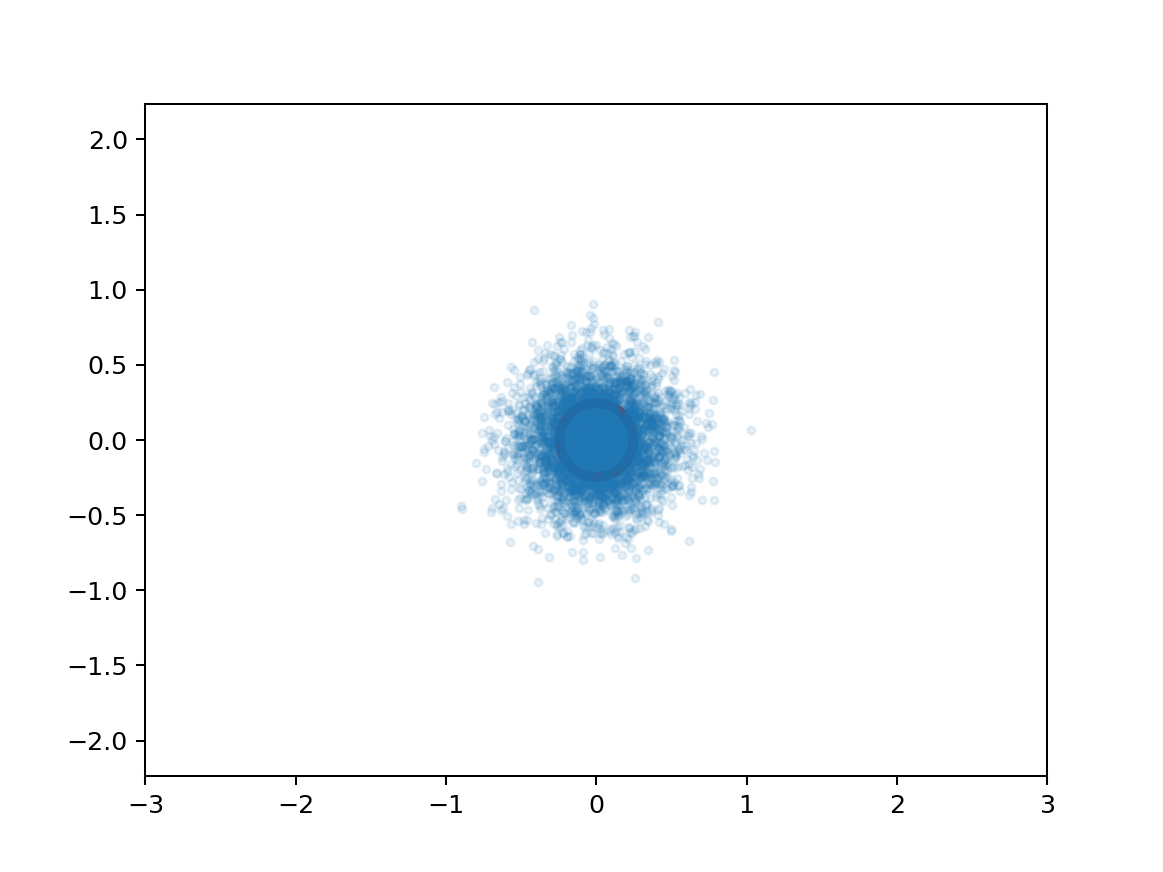

(-3, 3)

In [94]:
num_samples = 5000
covar = np.matrix(
    [
        [0.25, 0.0],
        [0.0, 0.25]
    ]
)
x = np.random.normal(loc=0, scale=covar[0, 0], size=num_samples)
y = np.random.normal(loc=0, scale=covar[1, 1], size=num_samples)

fig, ax = plt.subplots()
plt.plot(x, y, '.', alpha=0.1)
he = Ellipse([0,0], width=1.96*covar[0, 0], height=1.96*covar[1, 1], fill=False, linewidth=4, color='r')
ax.add_artist(he)

plt.axis('equal');

plt.xlim([-3, 3])
plt.ylim([-3, 3])

## Sigma points example

<IPython.core.display.Javascript object>


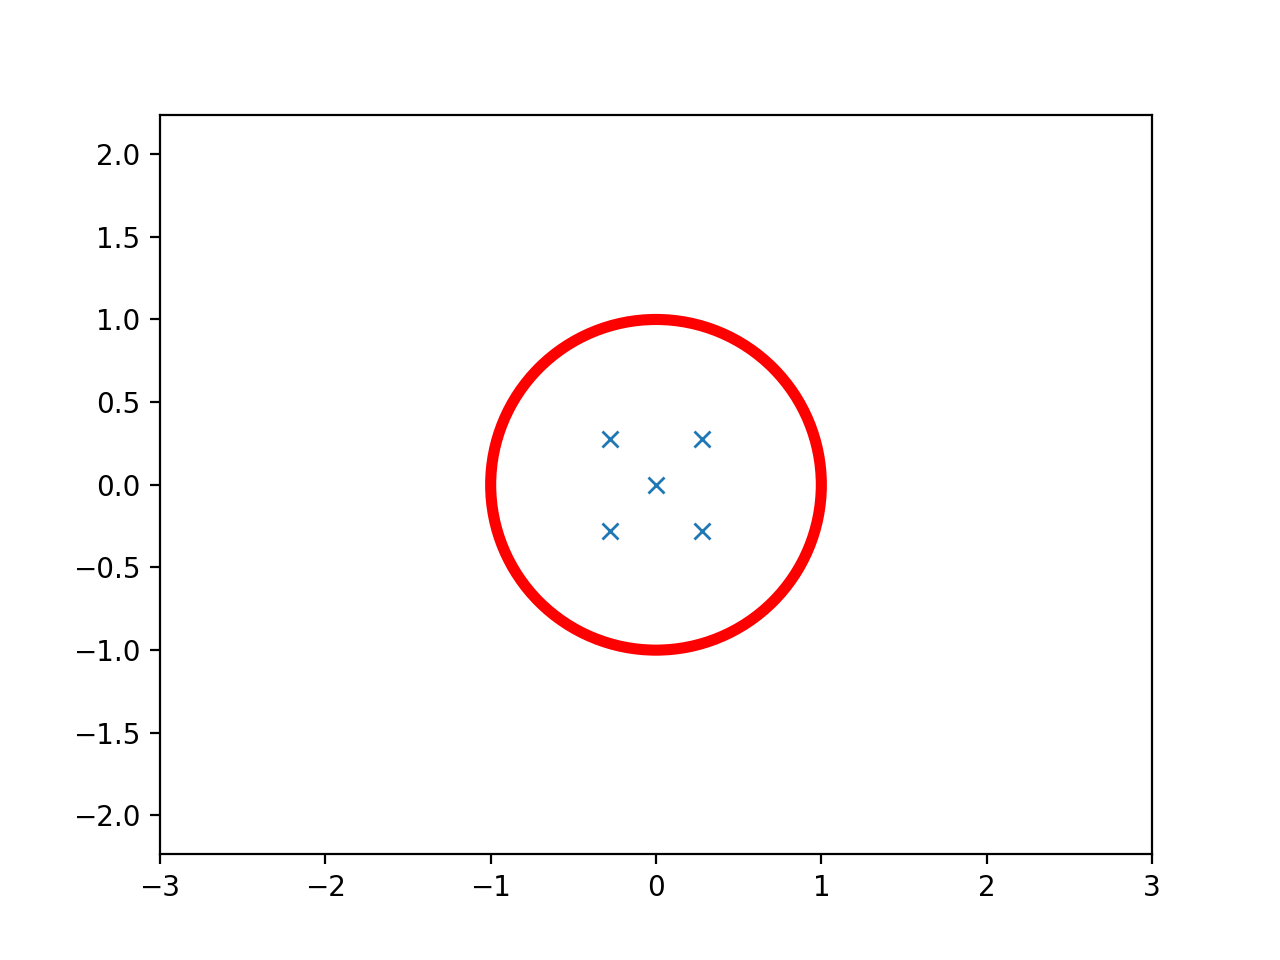

In [107]:
# compute sigma points
num_dim = 2
num_sigma_points = 2 * num_dim + 1
kappa = 3
alpha = 0.25
lmda = alpha**2 * (num_dim + kappa) - num_dim
beta = 2

mu = np.array([0, 0])
sigma_pts = np.empty([num_sigma_points, num_dim])
wm = np.empty([num_sigma_points]) # weight for mean (1st moment)
wc = np.empty([num_sigma_points]) # weight for covariance (2nd moment)
sigma_pts[0, :] = mu
wm[0] = lmda / (num_dim + lmda)
wc[0] = wm[0] + 1 - alpha**2 + beta

# Compute Sigma points
for i in range(num_dim):
    rhs = np.sqrt( (num_dim + lmda) * covar)
    rhs = np.array([rhs[0,0], rhs[1,1]])
    if i > 0: rhs[i-1] = -rhs[i-1]
    # Sigma points
    sigma_pts[2*i+1, :] = mu + rhs
    sigma_pts[2*i+2, :] = mu - rhs
    # weight for mean
    w = 1 / (2 * (num_dim + lmda))
    wm[2*i+1] = wm[2*i+2] = wc[2*i+1] = wm[2*i+2] = w

# visualize
fig, ax = plt.subplots()
he = Ellipse([0,0], width=8*covar[0, 0], height=8*covar[1, 1], fill=False, linewidth=4, color='r')
ax.add_artist(he)
plt.plot(sigma_pts[:, 0], sigma_pts[:, 1], 'x')

plt.axis('equal');

plt.xlim([-3, 3])
plt.ylim([-3, 3]);